In [2]:
#!pip install 'mahotas'

In [ ]:
import math
import itertools
import numpy as np

#import pylab as p
#import mahotas

In [4]:
EPS = 1E-9
P0 = -40  # dBm
reflection_coef = -12.03  # dB
transmission_coef = -0.5095  # dB
#reflection_coef = 0.25
#transmission_coef = 0.5
# Tx - user, Rx - AP

### Define classes for Point, Wall and Room instances

In [5]:
class Point:
    x = 0
    y = 0
    z = 0

    assigned_wall = None  # to which wall image point is assigned

    def __init__(self, x_, y_, z_):
        self.x = x_
        self.y = y_
        self.z = z_

    def __lt__(self, other):
        self_ = (self.x ** 2) + (self.y ** 2)
        other_ = (other.x ** 2) + (other.y ** 2)
        return self_ < other_

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ', ' + str(self.z) + ') '


In [6]:
class Wall:
    wall_number = 0
    p1 = Point
    p2 = Point
    p3 = Point
    p4 = Point

    def __init__(self, p1_, p2_, p3_, p4_, num):
        self.wall_number = num
        self.p1 = Point(p1_.x, p1_.y, p1_.z)
        self.p2 = Point(p2_.x, p2_.y, p2_.z)
        self.p3 = Point(p3_.x, p3_.y, p3_.z)
        self.p4 = Point(p4_.x, p4_.y, p4_.z)
        self.plane_equation = self.get_plane_equation()

    def __str__(self):
        print('Wall ' + str(self.wall_number) + ':')
        print(self.p1)
        print(self.p2)
        print(self.p3)
        print(self.p4)
        return ''

    def get_plane_equation(self):
        list = []
        list.append(
            det(self.p2.y - self.p1.y, self.p3.y - self.p1.y, self.p2.z - self.p1.z, self.p3.z - self.p1.z))
        list.append(
            -det(self.p2.x - self.p1.x, self.p3.x - self.p1.x, self.p2.z - self.p1.z, self.p3.z - self.p1.z))
        list.append(
            det(self.p2.x - self.p1.x, self.p3.x - self.p1.x, self.p2.y - self.p1.y, self.p3.y - self.p1.y))
        list.append(-self.p1.x * list[0] - self.p1.y * list[1] - self.p1.z * list[2])
        return list

In [7]:
# Let's take 15x10x4 meters room

In [8]:
class Room:
    AP = Point(2, 5, 1)
    length = 15
    width = 10
    height = 4
    walls = []

    def __init__(self):
        # walls
        self.walls.append(Wall(Point(0, 0, 0), Point(15, 0, 0), Point(15, 0, 4), Point(0, 0, 4), 1))
        self.walls.append(Wall(Point(15, 0, 0), Point(15, 10, 0), Point(15, 10, 4), Point(15, 0, 4), 2))
        self.walls.append(Wall(Point(15, 10, 0), Point(0, 10, 0), Point(0, 10, 4), Point(15, 10, 4), 3))
        self.walls.append(Wall(Point(0, 10, 0), Point(0, 0, 0), Point(0, 0, 4), Point(0, 10, 4), 4))
        # ceil
        self.walls.append(Wall(Point(0, 0, 4), Point(15, 0, 4), Point(15, 10, 4), Point(0, 10, 4), 5))
        # floor
        self.walls.append(Wall(Point(0, 0, 0), Point(15, 0, 0), Point(15, 10, 0), Point(0, 10, 0), 6))

    def __str__(self):
        for wall in self.walls:
            print(wall)
        return ''

### Path loss

_**Notes**_  
The maximum number of reflections _n_ is set to 3

#### Base model [ARIADNE]

$$ P(d)[dB] = P(d_0)[dB] - 10*n*log_{10}\frac{d}{d_0} $$

where P(d) is the power at distance d to the transmitter in meters; P(d0) is the power at a reference distance d0, usually set to 1.0 meter. n is the attenuation exponent, which is often statistically determined to provide a best fit with measurement readings.
[ARIADNE]
Simple attenuation model is in the form of Equation 1, and it is the base model for the other models.

In [9]:
def path_loss(room):
    Pr = 0 # power received (dBm)
    Pt = -40.0 # transmit power at AP (dBm)
    n = 5.0 # attenuation exponent (dBm)
    d = .0 # distance
    d0 = 1.0 # reference distance

    PrArr = []

    # iterate over all blocks
    for x in range(0, 10):
        for y in range(0,10):
            P = Point(x, y) # initial point
            intersections = 0 # num of intersections with walls
            d = math.sqrt((x - AP.x)**2 + (y - AP.y)**2) # distance from the AP
            
            # check if there're any intersections
            for w in room.walls: 
                intersections += w.isIntersected(P)
                
            if d == 0:
                Pr = Pt
            else:
                log = math.log10(d/d0)
                Pr = Pt - 10*n*log
            PrArr.append(Pr)
            
            #Set boundaries for color:
            if Pr > -20.0:
                Pr = -20.0
            if Pr < -80.0:
                Pr = -80.0

            #Set the Red and Green values based on Pr:
            Pr += 20.0
            if Pr > -30.0:
                Green = 255
                Red = -Pr * 255.0 / 30.0
            else:
                Green = 255 + (Pr + 30) * 255.0 / 30.0
                Red = 255

            #Write the pixel's color to the data array:
            #setpixel(data, (x + BORD), (y + BORD), Red, Green, 0);

#### Radio propagation model [ARIADNE]

the model is defined as:
    $$ P = \sum^{N_{r,j}}_{i=1}{(P_0 - 20log_{10}(d_i) - \gamma N_{i, ref} - \alpha N_{i, trans})} $$

where P is the power (in dB) at receiver, $ N_{r,j} $ is the total number
of rays received at the receiver j; $ P_0 $ is the power (in dB) at
a distance of 1 meter; $ d_i $, $ N_{i,ref} $, and $ N_{i,trans} $ represent the total
transmission distance, the total number of reflections and the total
number of (wall) transmissions of the ith ray, respectively. ÃÂ³ is the
reflection coefficient, and ÃÂ± is the transmission coefficient.

The initial values can be any positive numbers, however, better values
will minimize the search time. Generally, better values can be derived
from literature.

### Visualization of a map

### Room generation

### Evaluation

#### A general comparison metric is the least mean square error (LMSE) [ARIADNE}

$$ D = min_N^{k=1}\{\frac{1}{n}(\sum^{n}_{i=1}(ss_{m,i,k} - ss_{i,k})^2)^\frac{1}{2}\} $$

where D is the least mean square error, N is the total number of
records in the signal strength map table, k denotes the kth record
in the SS-MAP table; n is the number of sniffers. ssm,i,k denotes
measured signal strength at sniffer i of the mobile user, and ssi,k is
the signal strength record at a sniffer i in SS-MAP table.

### Main 

### Image tree construction

In [10]:
def det(a, b, c, d):
    return a * d - b * c


def get_direction_vector(a, b):
    return [b.x - a.x, b.y - a.y, b.z - a.z]

In [11]:
def build_image_tree(Tx, walls):
    layer_points = []

    for wall in walls:
        if wall != Tx.assigned_wall:
            pe = wall.plane_equation  # plane equation
            image_point = Point(0, 0, 0)
            common_part = (pe[0] * Tx.x + pe[1] * Tx.y + pe[2] * Tx.z +
                           pe[3]) / (pe[0] * pe[0] + pe[1] * pe[1] + pe[2] * pe[2])
            image_point.x = Tx.x - 2 * pe[0] * common_part
            image_point.y = Tx.y - 2 * pe[1] * common_part
            image_point.z = Tx.z - 2 * pe[2] * common_part
            image_point.assigned_wall = wall
            layer_points.append(image_point)
    return layer_points

In [12]:
def calculate_reflection_paths(image_tree, reflection_number, Tx, Rx):
    paths = []
    is_correct = True
    if reflection_number == 0:
        paths.append([Tx, Rx])
    else:
        for image_point in image_tree[-1]:
            path = [Rx]
            wall = image_point.assigned_wall
            p = intersect_line(Rx, image_point, wall)
            if p != -1:
                path.append(p)
            else:
                path.clear()
                is_correct = False
                continue
            for i in range(2, reflection_number + 1):
                wall = image_tree[-i][0].assigned_wall
                p = intersect_line(path[-1], image_tree[-i][0], wall)
                if p != -1:
                    is_correct = True
                    path.append(p)
                else:
                    path.clear()
                    is_correct = False
                    break
            if is_correct:
                path.append(Tx)
                path.reverse()
                paths.append(path)

    return paths

In [13]:
def check_if_point_belongs_to_wall(p, wall):
    if (p.x - wall.p1.x) * (p.x - wall.p3.x) <= 0 and (
                p.y - wall.p1.y) * (p.y - wall.p3.y) <= 0 and (
                p.z - wall.p1.z) * (p.z - wall.p3.z) <= 0:
        return True
    return False

In [14]:
def intersect_line(p1, p2, wall):
    intersect_epsilon = 0.1
    a = wall.plane_equation[0]
    b = wall.plane_equation[1]
    c = wall.plane_equation[2]
    direction_vector = get_direction_vector(p1, p2)

    num = (wall.p1.x - p1.x) * a + (wall.p1.y - p1.y) * b + (wall.p1.z - p1.z) * c
    denom = direction_vector[0] * a + direction_vector[1] * b + direction_vector[2] * c

    if denom == 0:
        return -1
    t = num / denom
    if t > intersect_epsilon:
        p = Point(0, 0, 0)
        p.x = p1.x + direction_vector[0] * t
        p.y = p1.y + direction_vector[1] * t
        p.z = p1.z + direction_vector[2] * t

        if math.fabs(p.x) < EPS: p.x = 0
        if math.fabs(p.y) < EPS: p.y = 0
        if math.fabs(p.z) < EPS: p.z = 0
        if check_if_point_belongs_to_wall(p, wall):
            return p
    return -1

In [15]:
def get_all_paths(walls, Tx, Rx):
    image_tree = [Tx]
    paths = [calculate_reflection_paths(image_tree, 0, Tx, Rx)]
    image_tree.append(build_image_tree(Tx, walls))  # first layer
    paths.append(calculate_reflection_paths(image_tree, 1, Tx, Rx))
    points_on_a_layer = len(image_tree[-1])
    for i in range(0, points_on_a_layer):
        image_tree.append(build_image_tree(image_tree[-1][0], walls))  # second layer
        paths.append(calculate_reflection_paths(image_tree, 2, Tx, Rx))
        points_on_a_layer_2 = len(image_tree[-1])
        for j in range(0, points_on_a_layer_2):
            image_tree.append(build_image_tree(image_tree[-1][0], walls))  # third layer
            paths.append(calculate_reflection_paths(image_tree, 3, Tx, Rx))
            # delete used 3rd layer and first point on 2nd (which is parent of 3rd)
            image_tree.pop(-1)
            image_tree[-1].pop(0)
            if len(image_tree[-1]) == 0:
                image_tree.pop(-1)

        image_tree[-1].pop(0)

    return list(itertools.chain.from_iterable(paths))

In [16]:
def get_reflection_length(a, b):
    return math.sqrt((b.x - a.x)**2 + (b.y - a.y)**2 + (b.z - a.z)**2)


def calculate_traversed_distance(path):
    traversed_distance = 0
    for i in range(0, len(path)-1):
        traversed_distance += get_reflection_length(path[i], path[i+1])
    return traversed_distance

In [17]:
# for one position
# from ARIADNE
def get_signal_strength(room, Tx):
    paths = get_all_paths(room.walls, Tx, room. AP)
    # calculate signal strength for each path, then sum
    signal_strength = 0
    for path in paths:
        num_of_reflections = len(path) - 2
        num_of_transmissions = 0  # TODO
        traversed_distance = calculate_traversed_distance(path)
        if traversed_distance == 0:
            return 0
        signal_strength += (P0 - 10*math.log10(traversed_distance) - reflection_coef*num_of_reflections + 
                            transmission_coef*num_of_transmissions)
    #signal_strength /= len(paths)
    return round(signal_strength, 3)

In [18]:
def calculate_signal_strength_matrix(room, signal_strength_matrix):
    #signal_strength_matrix = np.zeros((room.length, room.width, room.height))
    for x in range(0, room.length):
        for y in range(0, room.width):
            for z in range(room.height):
                signal_strength_matrix[x][y][z] = get_signal_strength(room, Point(x, y, z))

In [19]:
######

In [20]:
room = Room()
signal_strength_ma = np.zeros((room.length, room.width, room.height))
calculate_signal_strength_matrix(room, signal_strength_ma)

for x in range(0, room.length):
        for y in range(0, room.width):
            print(signal_strength_ma[x][y][3], end = " " )
        print()
print()

-1166.929 -1217.178 -1228.852 -1153.55 -1151.407 -1029.935 -1151.407 -1153.55 -1228.852 -1217.178 
-1212.248 -1180.708 -1174.899 -1168.079 -1115.39 -994.213 -1115.39 -1149.048 -1174.899 -1180.708 
-1230.749 -1199.185 -1191.868 -1203.802 -1077.76 -940.326 -1077.76 -1203.802 -1191.868 -1199.185 
-1235.021 -1141.028 -1153.837 -1166.898 -1099.167 -1073.201 -1099.167 -1166.898 -1137.415 -1141.028 
-1141.727 -1091.492 -1104.474 -1175.784 -1107.882 -1025.727 -1107.882 -1175.784 -1104.474 -1091.492 
-805.228 -758.011 -835.478 -849.95 -851.143 -882.884 -851.913 -851.497 -837.816 -761.161 
-1120.026 -1053.35 -1105.084 -1053.78 -1072.163 -1102.843 -1072.163 -1053.78 -1105.084 -1053.35 
-1123.728 -1092.584 -1089.795 -1058.142 -1141.433 -1106.902 -1141.433 -1058.142 -1089.795 -1092.584 
-1141.319 -1090.846 -1105.028 -1038.479 -1140.052 -1105.438 -1140.052 -1038.479 -1105.028 -1090.846 
-1129.27 -1097.402 -1029.955 -1127.598 -1109.904 -1093.637 -1109.904 -1127.598 -1029.955 -1097.402 
-1192.668 -116

## Tests

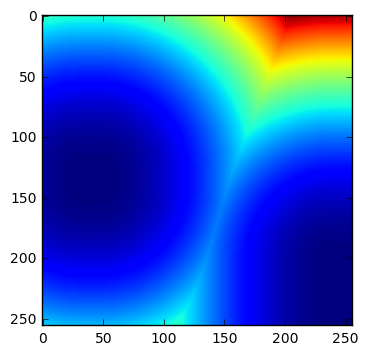

In [23]:
import pylab as p
import numpy as np
import mahotas

f = np.ones((256,256), bool)
f[200:,240:] = False
f[128:144,32:48] = False
# f is basically True with the exception of two islands: one in the lower-right
# corner, another, middle-left

dmap = mahotas.distance(f)
p.imshow(dmap)
p.show()